# RESULTS - STARR

In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
if sys.version_info[0] == 3:
    from importlib import reload
import warnings
warnings.filterwarnings('ignore')

os.chdir('/share/pi/boussard/eroosli_work/benchmarking')
import models.evaluation.learningcurves as lc
import models.evaluation.calibration as cb
import models.evaluation.performance as pm

In [2]:
json_strat = json.load(open('models/outputs/starr/predictions/confvals/2020-06-03_9-15.stratified_ihm_results.json'))
json_nonstrat = json.load(open('models/outputs/starr/predictions/confvals/2020-06-03_9-54.nonstratified_ihm_results.json'))

# Performance analysis

### Part 1: Discrimination

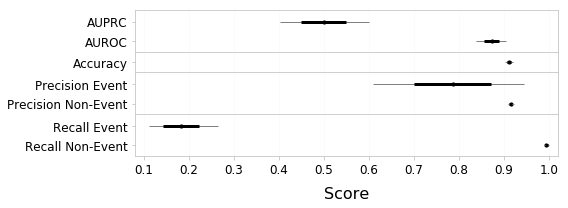

In [3]:
output_json = json_strat
pm.plot_metrics_overall(output_json, 'starr')

> COMPARISON: 
- generally larger variation in STARR (smaller testset)
- PRC, ROC and accuracy very similar
- precision & recall: 
    - non-event: very similar
    - event: higher precision, lower recall

### Part 2: Calibration

- Number of Hosmer-Lemeshow groups = 10
- Nonparametric LOWESS smoothing considers 50% of points for each estimation
- Red line: decision threshold used for binary prediction (at predicted risk = 50%)

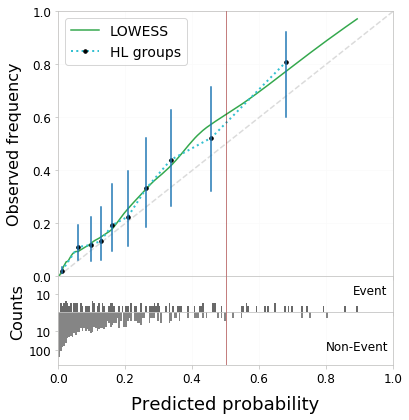

In [4]:
path_results = 'models/outputs/starr/predictions/results/TEST.2020-06-02_17-31.k_clstms.NONE.csv'
results = cb.results_csv(path_results)
cb.calibration_overall(results, "overall", data='starr')

> Calibration: 
- IHM risk is consistenly understimated (not the case for MIMIC)
- Only one HL group is above the decision threshold, compared to two groups in MIMIC

# Fairness Analysis

## Concept #1: Anti-classification

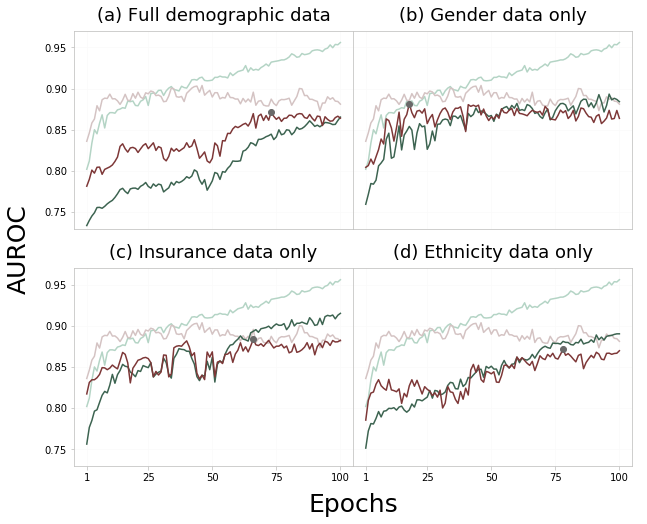

In [15]:
reload(lc)
path_keras_logs = 'models/outputs/starr/keras_logs'
path_clstm_basic = os.path.join(path_keras_logs, '2020-06-02_8-59.k_clstms.NONE.csv')
epochs_cbasic = lc.epoch_csv(path_clstm_basic)
path_clstm_aug = os.path.join(path_keras_logs, '2020-06-03_17-50.k_clstms.GEN_ETH_INS.csv')
epochs_aug = lc.epoch_csv(path_clstm_aug)
path_clstm_gen = os.path.join(path_keras_logs, '2020-06-02_11-8.k_clstms.GEN.csv')
epochs_gen = lc.epoch_csv(path_clstm_gen)
path_clstm_ins = os.path.join(path_keras_logs, '2020-06-02_12-52.k_clstms.INS.csv')
epochs_ins = lc.epoch_csv(path_clstm_ins)
path_clstm_eth = os.path.join(path_keras_logs, '2020-06-02_12-37.k_clstms.ETH.csv')
epochs_eth = lc.epoch_csv(path_clstm_eth)
dfs = [epochs_aug, epochs_gen, epochs_ins, epochs_eth]
lc.plot_learningcurves_2by2(dfs, epochs_cbasic, data='starr')

> COMPARISON:
- baseline performance in terms of ROC is better for STARR than for MIMIC (0.90 vs. 0.86)
- similar pattern with augmented models: perform worse

## Concept #2: Classification parity

- 10'000 bootstrapping on test set (resampling with replacement, while keeping proportions of outcomes fixed for every demographic group)
- 95% confidence intervals (grey line), SD in bold black, dot indicates median value

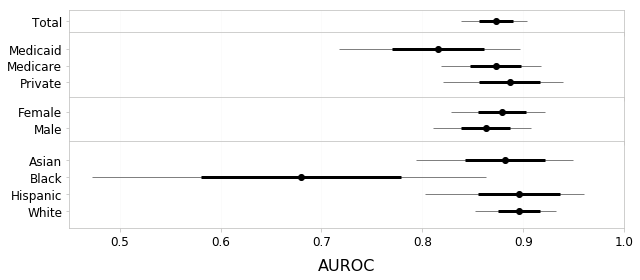

In [6]:
output_json = json_strat
reload(pm)
pm.plot_metric_grouped(output_json, "AUC of ROC", 'starr')

> Comparison:
- Overall AUC slightly higher: 0.87 vs. 0.86
- Insurance:
    - private insurance in both cases best, though difference less marked for STARR
    - same pattern for Medicaid and Medicare
- Gender: pattern is reversed, females have better scores in STARR
- Ethnicity:
    - STARR: Marked difference for black patients, other three quite similar

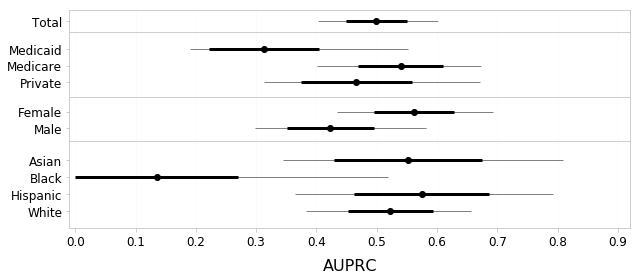

In [7]:
pm.plot_metric_grouped(output_json, "AUC of PRC", 'starr')

> Comparison:
- Totals are very close to each other
- Insurance: Same pattern, Medicaid disadvantaged
- Gender: Females better (bigger difference in STARR)
- Ethnicity: Again, huge disadvantage for black patients

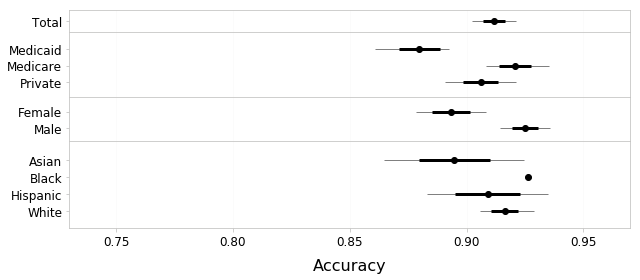

In [8]:
pm.plot_metric_grouped(output_json, "Accuracy", 'starr')

> Comparison:
- Overall slightly higher accuracy here (might be connected to higher IHM rate though)
- Insurance: Medicare best, big differences overall
- Gender: Male much better than Female (contrary to the first two results) --> linked to lower IHM rate?
- Ethnicity: 
    - Black: highest accuracy, but due to not predicting any negatives (IHM rate is 7.3% in testset, see for FNR and FPR)
    - White: second highest
    - Hispanic & Asian: high variability

> **Summary of last three plots:**
- Insurance:
    - Medicare: consistently very good
    - Medicaid: consistently worst
    - Private: best in ROC, second-best for other two metrics
- Gender: Female better for ROC and PRC, but strikingly worse for accuracy
- Ethnicity:
    - Black: worst for ROC and PRC, no positives coupled with low IHM rate makes accuracy sky-rocket but model proves totally useless in this case
    - White: consistently good
    - Hispanics and Asians: similar results

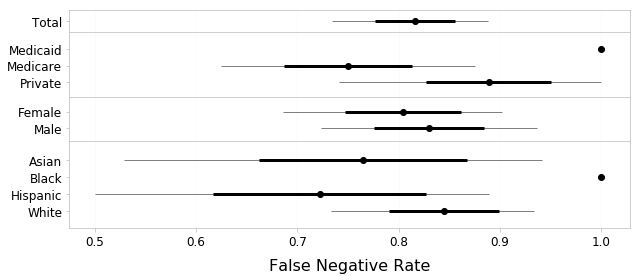

In [9]:
pm.plot_metric_grouped(output_json, "False Negative Rate", 'starr')

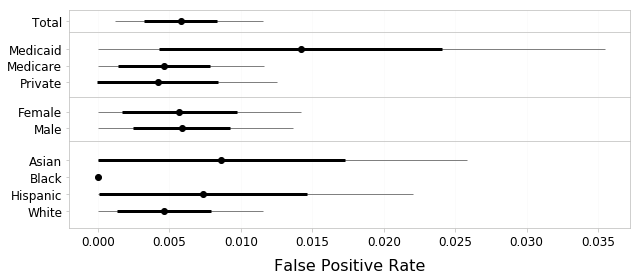

In [10]:
pm.plot_metric_grouped(output_json, "False Positive Rate", 'starr')

> - large variation for ethnic groups (except white): due to small sample size
> - gender differences not significant
> - insurance type has interesting results, especially for AUC-ROC and Accuracy
> - other plot idea: different metrics for insurance in same plot
> - false negative rate very high
> - **Q**: plots for which metrics make sense (to e.g. keep for thesis)? 

## Concept #3: Calibration

### A) Mean calibration (*calibration-in-the-large*)

10'000 bootstrapping without stratification for confidence intervals (**100'000** also tested)

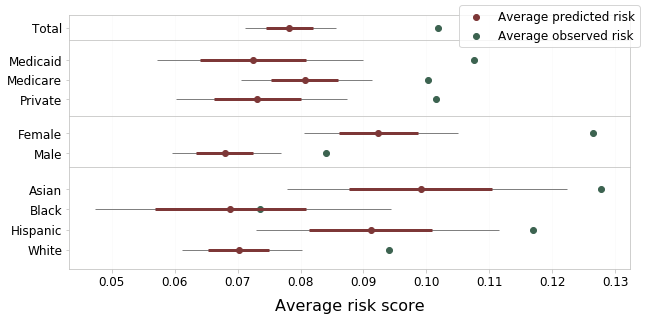

In [11]:
reload(cb)
output_json = json_strat
cb.plot_calibration_mean_strat(output_json, 'starr')

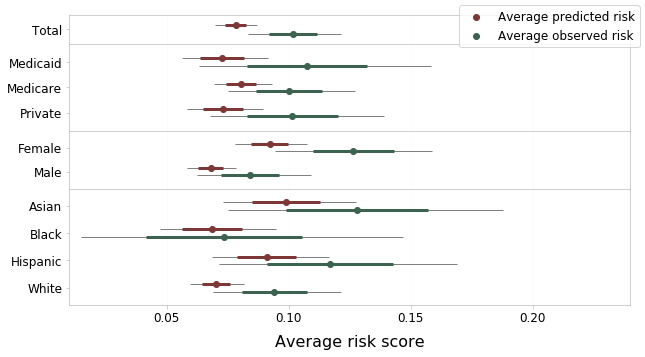

In [12]:
reload(cb)
output_json = json_nonstrat
cb.plot_calibration_mean(output_json, 'starr')

> Comparison:
- Risk is again underestimated overall (by roughly 2%)
- Insurance: share same pattern of risk underestimation, Medicare has the smallest divergence in average predicted and observed risk
- Gender: comparable divergence; higher risk is predicted for females, though still underestimated
- Ethnicity: 
    - White: similar pattern as for overall prediction pattern/behavior
    - Hispanic & Asian: comparable pattern, just slightly shifted to a higher risk level for Asian patients
    - Black: overall good calibration, though very high variation in the average observed risk

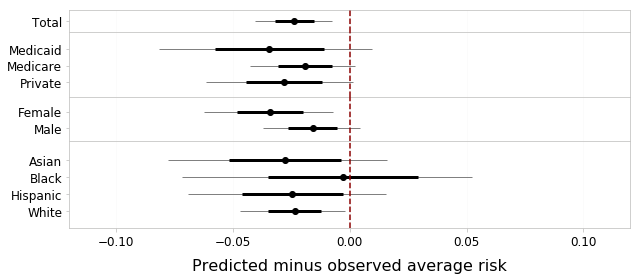

In [13]:
reload(cb)
cb.plot_calibration_diffs(output_json, 'starr')

> Comparison:
- Consistent underestimation of risk, only statistically significant for overall model, females and white patients however
- Black patients again best calibration results
- Overall very high variation in model calibration: linked to much smaller testset compared to MIMIC
- Patterns overall very different from results in MIMIC

### B) Calibration plots

**Insurance**

In [14]:
results_priv = results[results["Insurance"] == 4].copy()
results_medicare = results[results["Insurance"] == 2].copy()
results_medicaid = results[results["Insurance"] == 3].copy()
results_pub = results[(results["Insurance"] == 1) | (results["Insurance"] == 2) | (results["Insurance"] == 3)].copy()

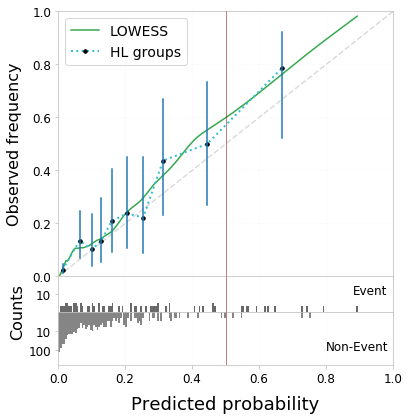

In [15]:
reload(cb)
cb.calibration_overall(results_pub, "pub_ins", data='starr')

> consistent underestimation of risk, worsens for higher risk patients; up to roughly 20% discrepancy in IHM risk

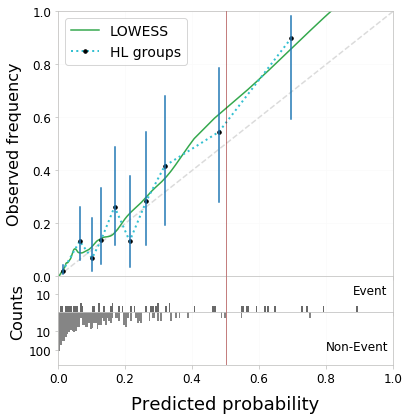

In [16]:
cb.calibration_overall(results_medicare, "pub_medicare", data='starr')

> similar pattern as for overall public insurance cohort

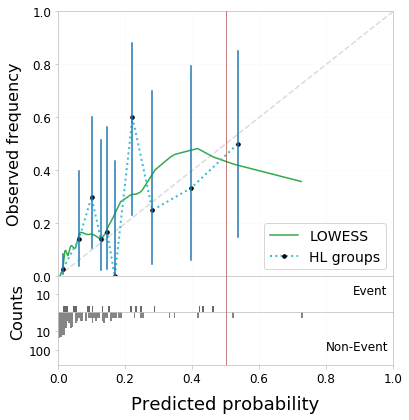

In [17]:
cb.calibration_overall(results_medicaid, "pub_medicaid", data='starr')

> bad risk underestimation especially for low and medium risk patients

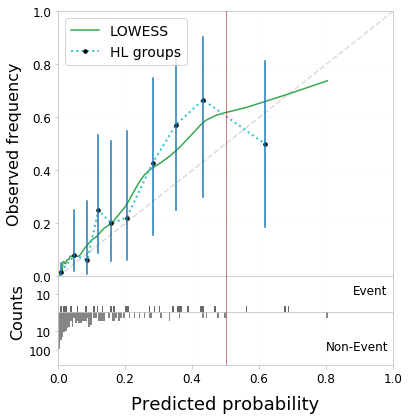

In [18]:
cb.calibration_overall(results_priv, "priv_ins", data='starr')

> bad risk underestimation particularly for medium-risk patients

**Gender**

In [19]:
results_F = results[results["Gender"] == 1].copy()
results_M = results[results["Gender"] == 2].copy()

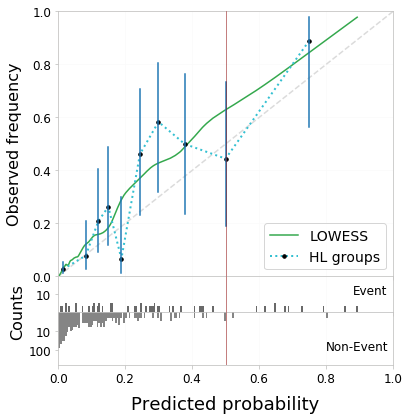

In [20]:
cb.calibration_overall(results_F, "gen_F", data='starr')

> calibration okay for very low-risk patients, but bad consistent risk underestimation for everyone else

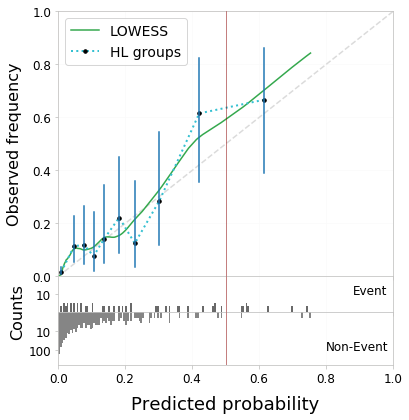

In [21]:
reload(cb)
cb.calibration_overall(results_M, "gen_M", data='starr')

> good calibration for low-medium risk patients, but risk underestimation particularly for higher risk patients

**Ethnicity**

In [22]:
results_asian = results[results["Ethnicity"] == 1].copy()
results_black = results[results["Ethnicity"] == 2].copy()
results_white = results[results["Ethnicity"] == 4].copy()
results_hispa = results[results["Ethnicity"] == 3].copy()

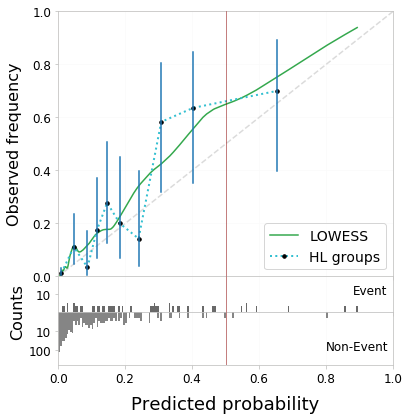

In [23]:
cb.calibration_overall(results_white, "eth_white", data='starr')

> strong risk underestimation for medium to high risk patients

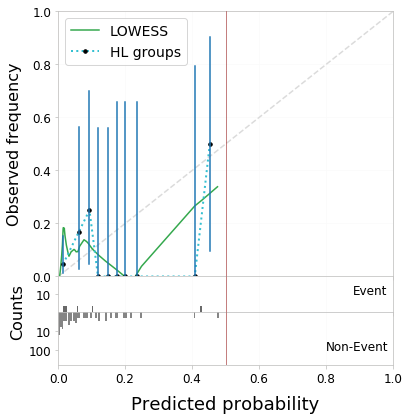

In [24]:
cb.calibration_overall(results_black, "eth_black", data='starr')

> very bad calibration, although this is also partly due to an extremely small testset for black patients in STARR; no patient gets a positive prediction, the patient with the the highest predicted risk does not end up dying in hospital. Overall, there is a spiked risk underestimation for very low risk patients, but a risk overestimation for medium risk patients (nobody of several groups ends up dying).

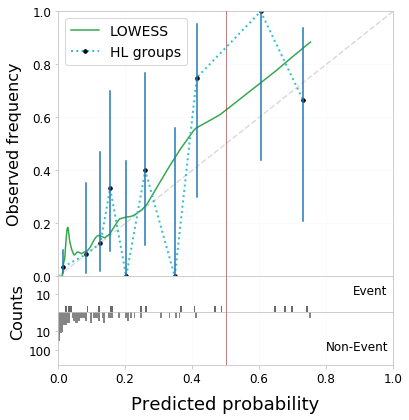

In [25]:
cb.calibration_overall(results_asian, "eth_asian", data='starr')

> pronounced spike again for very low risk patients (only captured by LOWESS), followed by a short range of good calibration and a subsequent de-calibration for high risk patients

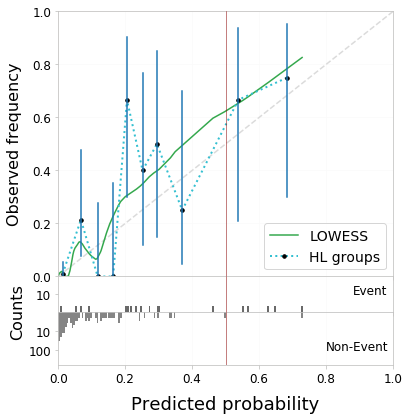

In [26]:
cb.calibration_overall(results_hispa, "eth_hispa", data='starr')

> unstable for low risk patients, then consistently underestimating IHM risk